In [1]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=1,
                       memory ='100GB',
                       walltime="12:00:00")


In [2]:
# Call at head node, otherwise you won't get the dashboard
from dask.distributed import Client
cluster.scale(1) # number of nodes you request
client = Client(cluster)
client

Client Scheduler: tcp://128.104.200.53:45523 Dashboard: http://128.104.200.53:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [1]:
def map8bit(data):
      return ((data - data.min())/(data.max() - data.min())*255).astype('int8')

def Reconstruction(signal_slice, cx, cy, BF_radius, withADF, thres):
    
    signal_slice.data[signal_slice.data<thres] = 0
    rx,ry,kx,ky = signal_slice.data.shape
    PACBED = np.zeros((kx,ky))
    #COM = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210621/86000fpsA30um/BlankCOM.npy')##############

    kx = np.linspace(0,kx-1,kx)
    ky = np.linspace(0,ky-1,ky)
    kx2,ky2 = np.meshgrid(ky,kx)## swaped

    COM_exp = np.zeros((rx,ry,2))
    COM_exp_ang = np.zeros((rx,ry))
    BF = np.zeros((rx,ry))
    ABF = np.zeros((rx,ry))
    eBF = np.zeros((rx,ry))
    ADF = np.zeros((rx,ry))

    ABF_radius = BF_radius/2
    ADF_radius = BF_radius*1.36

    for ix in range(rx):
        for iy in range(ry):

            frame = signal_slice.data[ix,iy,:,:]

            #cx = COM[ix,iy,0]
            #cy = COM[ix,iy,1]

            distance_from_center = np.sqrt((kx2 - cx)**2 + (ky2-cy)**2)
            ADF_mask = (distance_from_center > (BF_radius)) & (distance_from_center <= (ADF_radius))
            ABF_mask = (ABF_radius <= distance_from_center) & (distance_from_center <= BF_radius)
            BF_mask = distance_from_center <= BF_radius
            lBF_mask = distance_from_center <= ABF_radius

            #res = ndimage.measurements.center_of_mass(signal_slice.data[ix,iy,:,:]*BF_mask)
            #COM_exp[ix,iy,0] = res[0]-cx
            #COM_exp[ix,iy,1] = res[1]-cy        
            BF[ix,iy] = (frame*BF_mask).sum()
            #ABF[ix,iy] = (frame*ABF_mask).sum()
            ADF[ix,iy] = (frame*ADF_mask).sum() if withADF else None
            #eBF[ix,iy] = ABF[ix,iy]-(frame*lBF_mask).sum()
            PACBED = PACBED + frame
    
    return COM_exp, BF, ABF, eBF, PACBED, ADF

In [1]:
import time
import SeqIO
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import time
import glob,os
#import cv2
from scipy import optimize
from skimage import feature
from pylab import *
import struct
#import mrcfile
import math
import sys
import h5py
#from skimage import data, color
from scipy import ndimage
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.morphology import disk
from skimage.morphology import closing
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange
import hyperspy.api as hs
from hyperspy import io_plugins
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Seq to ADFs

In [3]:
signal = SeqIO.load_folder('/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/Rawdata/movie433/',lazy=True, chunk_shape=(1, 64,64), nav_shape=(40, 256,256))

In [ ]:
ss = signal.inav[:,:,2]
ss.compute()

<IPython.core.display.Javascript object>


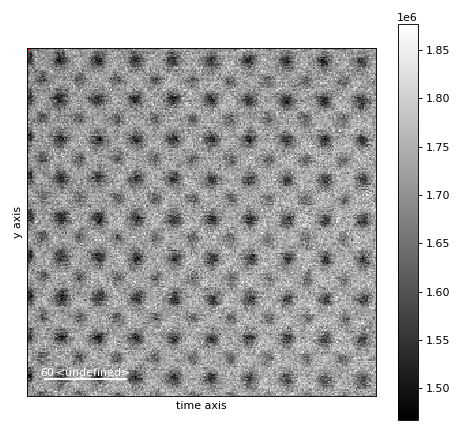

<IPython.core.display.Javascript object>


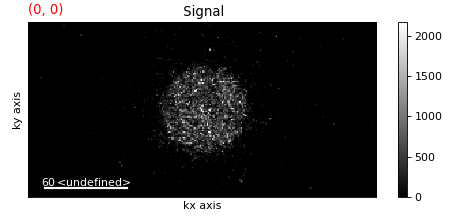

In [44]:
%matplotlib notebook
ss.plot()

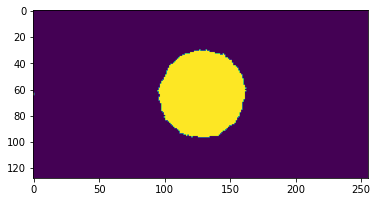

In [40]:
sample = ss.sum().data/10000
bw = 1.0*(sample > 600)
plt.imshow(bw)
selem = disk(3)
bw2 = closing(bw, selem)
plt.imshow(bw2)
edges = feature.canny(bw2)

[131 132 126] [60 59 67] [31 30 30]
129 62 30


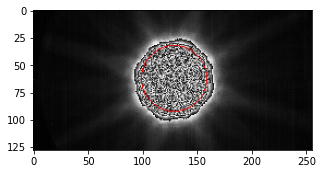

cx axis1: 129 cy axis2: 62 radius: 30


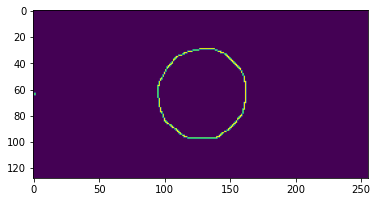

In [43]:
%matplotlib inline
sample = ss.sum().data/10000
bw = 1.0*(sample > 450)
selem = disk(3)
bw2 = closing(bw, selem)
edges = feature.canny(bw2)

#sample = sample*bw*1000000
sample = sample.astype('uint8')
temp = edges.astype('uint8')
# plt.imshow(sample)
# plt.colorbar()

image = sample

# Detect two radii
hough_radii = np.arange(29,32,1)
hough_res = hough_circle(temp, hough_radii)

# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3)

print(cx,cy,radii)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
image = color.gray2rgb(image)
cx = int(np.average(cx))
cy = int(np.average(cy))
radii = int(np.average(radii))

print(cx,cy,radii)
circy, circx = circle_perimeter(cy,cx,radii)
# circy, circx = circle_perimeter(290,262,181)
image[circy, circx] = (220, 20, 20)

# for center_y, center_x, radius in zip(cy, cx, radii):
#     circy, circx = circle_perimeter(center_y, center_x, radius)
#     image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()
plt.imshow(temp)
print('cx axis1:', cx,'cy axis2:',cy,'radius:',radii)

compute() the same variable again lead to memory error?

In [4]:
signal.set_signal_type('electron_diffraction')


COMseries = np.ones((40,256,256,2))
BFseries = np.ones((40,256,256))
eBFseries = np.ones((40,256,256))
#PACBEDseries = np.ones((40,128,128))
PACBEDseries = np.ones((40,128,256))
ADFseries = np.ones((40,256,256))

thres = 7
cx = 129
cy = 62
BFradius = 30
'''
with open(folder + 'reconstruction_par.txt', 'w') as f:
    f.write('threshold = '+ str(thres))
    f.write('\ncx = '+str(cx))
    f.write('\ncy = '+ str(cy))
    f.write('\nBFradius = '+ str(BFradius))
    f.write('\ncroph = '+ str(croph))
    f.write('\ncropv = '+ str(cropv))
'''

for fc in range(signal.data.shape[0]):

    print('Working on: Slice',fc)
    signal_slice = signal.inav[:,:,fc]
    signal_slice.compute()
    

    COM_exp, BF, ABF, eBF, PACBED, ADF = Reconstruction(signal_slice, cx, cy, BFradius, withADF = True, thres = thres)
    #COMseries[fc] = COM_exp
    BFseries[fc] = BF
    #eBFseries[fc] = eBF
    PACBEDseries[fc] = PACBED
    ADFseries[fc] = ADF
    del signal_slice

Working on: Slice 0
[########################################] | 100% Completed | 29.2s
Working on: Slice 1
[########################################] | 100% Completed | 29.3s
Working on: Slice 2
[########################################] | 100% Completed | 29.0s
Working on: Slice 3
[########################################] | 100% Completed | 29.1s
Working on: Slice 4
[########################################] | 100% Completed | 28.4s
Working on: Slice 5
[########################################] | 100% Completed | 28.6s
Working on: Slice 6
[########################################] | 100% Completed | 28.7s
Working on: Slice 7
[########################################] | 100% Completed | 29.5s
Working on: Slice 8
[########################################] | 100% Completed | 29.3s
Working on: Slice 9
[########################################] | 100% Completed | 30.0s
Working on: Slice 10
[########################################] | 100% Completed | 29.7s
Working on: Slice 11
[#########

In [9]:
path = '/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/Rawdata/movie433/'
np.save( path + 'BFseries.npy', BFseries)
np.save( path + 'ADFseries.npy', ADFseries)
np.save( path + 'PACBEDseries.npy', PACBEDseries)

In [10]:
#path = '/srv/home/jwei74/4DSTEMdata/20210920STOthin/movie222/'
BF = np.load(path + 'BFseries.npy')
ADF = np.load(path + 'ADFseries.npy')
#COM = np.load(path + 'COMseries.npy')
PACBED = np.load(path + 'PACBEDseries.npy')

In [12]:
frame = 30
COM_exp_mag = np.sqrt(COM[frame,:,:,0]**2 + COM[frame, :,:,1]**2)

NameError: name 'COM_exp_mag' is not defined

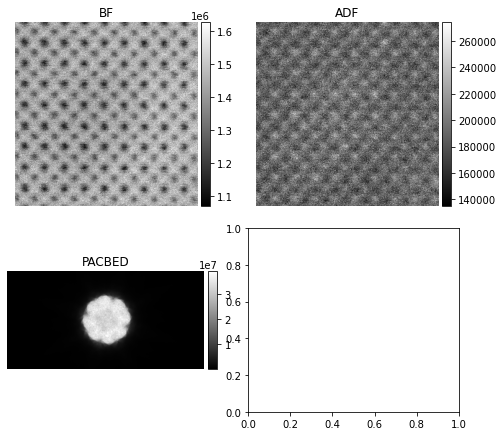

In [11]:
frame = 30
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig0, ax0 = plt.subplots(nrows=2, ncols=2, figsize = (7,6))
fig0.tight_layout(h_pad = .1, w_pad = 0)
a = ax0[0,0].imshow(BF[frame,:, 1:-1,], cmap = 'gray')
divider = make_axes_locatable(ax0[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(a,cax = cax)
ax0[0,0].set_title('BF')
ax0[0,0].axis('off')

b = ax0[0,1].imshow(ADF[frame, :, 1:-1], cmap = 'gray')
divider = make_axes_locatable(ax0[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(b,cax = cax)
ax0[0,1].set_title('ADF')  
ax0[0,1].axis('off')

c = ax0[1,0].imshow(PACBED[frame, 1:-1,1:-1], cmap = 'gray')
divider = make_axes_locatable(ax0[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(c,cax = cax)
ax0[1,0].set_title('PACBED')      
ax0[1,0].axis('off')  

d = ax0[1,1].imshow(COM_exp_mag[:, 2:-1], cmap = 'gray')
divider = make_axes_locatable(ax0[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(d,cax = cax)
ax0[1,1].set_title('COM_magnitude')      
ax0[1,1].axis('off') 
  

# NRR

In [20]:
from pymatchseries import MatchSeries
# load the image stack
calculation = MatchSeries(ADF)                 # initialize the calculation


In [18]:
calculation.configuration

{'templateNamePattern': 'input/frame_%02d.tiff',
 'templateNumOffset': 0,
 'templateNumStep': 1,
 'numTemplates': 40,
 'templateSkipNums': [],
 'preSmoothSigma': 0,
 'dontNormalizeInputImages': 0,
 'enhanceContrastSaturationPercentage': 0.15,
 'normalizeMinToZero': 1,
 'useCorrelationToInitTranslation': 0,
 'maxCorrShift': 0,
 'maxGDIterations': 500,
 'stopEpsilon': 1e-06,
 'lambda': 200,
 'lambdaFactor': 1,
 'startLevel': 6,
 'stopLevel': 8,
 'precisionLevel': 8,
 'refineStartLevel': 7,
 'refineStopLevel': 8,
 'checkboxWidth': 8,
 'resizeInput': 0,
 'numExtraStages': 2,
 'extraStagesLambdaFactor': 0.1,
 'resampleInsteadOfProlongateDeformation': 1,
 'dontAccumulateDeformation': 0,
 'useMedianAsNewTarget': 1,
 'skipStage1': 0,
 'reuseStage1Results': 1,
 'reduceDeformations': 1,
 'saveDirectory': 'output/',
 'calcInverseDeformation': 0,
 'onlySaveDisplacement': 1,
 'saveNamedDeformedTemplates': 0,
 'saveNamedDeformedTemplatesUsingNearestNeighborInterpolation': 0,
 'saveNamedDeformedTempl

In [21]:
calculation.run()  

Directory output/ already exists
reading reference image from: input/frame_00.tiff
reading template image from: input/frame_00.tiff
Created directory output/stage1/
Using templates images ---------------------------------------
input/frame_01.tiff
input/frame_02.tiff
input/frame_03.tiff
input/frame_04.tiff
input/frame_05.tiff
input/frame_06.tiff
input/frame_07.tiff
input/frame_08.tiff
input/frame_09.tiff
input/frame_10.tiff
input/frame_11.tiff
input/frame_12.tiff
input/frame_13.tiff
input/frame_14.tiff
input/frame_15.tiff
input/frame_16.tiff
input/frame_17.tiff
input/frame_18.tiff
input/frame_19.tiff
input/frame_20.tiff
input/frame_21.tiff
input/frame_22.tiff
input/frame_23.tiff
input/frame_24.tiff
input/frame_25.tiff
input/frame_26.tiff
input/frame_27.tiff
input/frame_28.tiff
input/frame_29.tiff
input/frame_30.tiff
input/frame_31.tiff
input/frame_32.tiff
input/frame_33.tiff
input/frame_34.tiff
input/frame_35.tiff
input/frame_36.tiff
input/frame_37.tiff
input/frame_38.tiff
input/frame_

 29 steps, tau:    0     , sigma:  1.e-04 energy: -0.758913585845 5 steps, tau:    1.0000, sigma:  1.0000 energy: -0.758400349688
Descent needed 29 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.458557965404
 25 steps, tau:    0     , sigma:  1.e-04 energy: -0.459099231985
Descent needed 25 step(s).
Created directory output/stage1/5-r/

--------------------------------------------------------
Registration on level 7 started
--------------------------------------------------------

Initial energy: -0.679134492509
 37 steps, tau:    0     , sigma:  1.e-04 energy: -0.68700964671634 steps, tau:    0     , sigma:  1.e-03 energy: -0.687009646716
Descent needed 37 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.447698394326
 50 steps, tau: 

 42 steps, tau:    0     , sigma:  1.e-04 energy: -0.762249904472
Descent needed 42 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.480513346845
 72 steps, tau:    0     , sigma:  1.e-04 energy: -0.524008119001
Descent needed 72 step(s).
Created directory output/stage1/16-r/

--------------------------------------------------------
Registration on level 7 started
--------------------------------------------------------

Initial energy: -0.606974867540
 22 steps, tau:    0     , sigma:  1.e-04 energy: -0.631192176596
Descent needed 22 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.403755393224
 39 steps, tau:    0     , sigma:  1.e-04 energy: -0.435076999975
Descent needed 39 step(s).
Created directory output/stage1/17/

-------------

 48 steps, tau:    0     , sigma:  1.e-04 energy: -0.778170798752
Descent needed 48 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.517924077850
 41 steps, tau:    0     , sigma:  1.e-04 energy: -0.557930541469 7 steps, tau:    0.1250, sigma:  1.0000 energy: -0.555576209499
Descent needed 41 step(s).
Created directory output/stage1/27-r/

--------------------------------------------------------
Registration on level 7 started
--------------------------------------------------------

Initial energy: -0.619860378197
 28 steps, tau:    0     , sigma:  1.e-04 energy: -0.624721269170
Descent needed 28 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.379124541351
 52 steps, tau:    0     , sigma:  1.e-04 energy: -0.426462450590
Descent neede

 50 steps, tau:    0     , sigma:  1.e-04 energy: -0.417400063346
Descent needed 50 step(s).
Created directory output/stage1/33/

--------------------------------------------------------
Registration on level 6 started
--------------------------------------------------------

Initial energy: -0.837108556109
 21 steps, tau:    0     , sigma:  1.e-04 energy: -0.851678069647
Descent needed 21 step(s).

--------------------------------------------------------
Registration on level 7 started
--------------------------------------------------------

Initial energy: -0.748354892740
 21 steps, tau:    0     , sigma:  1.e-04 energy: -0.748841713599
Descent needed 21 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.486769718944
 43 steps, tau:    0     , sigma:  1.e-04 energy: -0.540141931247 2 steps, tau:    8.0000, sigma:  1.0000 energy: -0.518619325190
Descent needed 

 52 steps, tau:    0     , sigma:  1.e-04 energy: -0.87939645032616 steps, tau:    1.0000, sigma:  1.0000 energy: -0.874794566914
Descent needed 52 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.684771008324
 61 steps, tau:    0     , sigma:  1.e-04 energy: -0.763047887037
Descent needed 61 step(s).
Created directory output/stage2/7-r/

--------------------------------------------------------
Registration on level 7 started
--------------------------------------------------------

Initial energy: -0.837680812796
 66 steps, tau:    0     , sigma:  1.e-04 energy: -0.87536468611934 steps, tau:    2.0000, sigma:  1.0000 energy: -0.872929639739
Descent needed 66 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.700843946277
161 steps, tau: 

 37 steps, tau:    0     , sigma:  1.e-04 energy: -0.883671434992
Descent needed 37 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.751554635057
 97 steps, tau:    0     , sigma:  1.e-04 energy: -0.79755669760227 steps, tau:    0.5000, sigma:  0.5000 energy: -0.788486890074
Descent needed 97 step(s).
Created directory output/stage2/20-r/

--------------------------------------------------------
Registration on level 7 started
--------------------------------------------------------

Initial energy: -0.882955268871
 47 steps, tau:    0     , sigma:  2.e-04 energy: -0.89240517851448 steps, tau:    0     , sigma:  1.e-04 energy: -0.892405178514
Descent needed 48 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.700287274060
143 steps, tau:

 49 steps, tau:    0     , sigma:  1.e-04 energy: -0.86645019689519 steps, tau:    0.0312, sigma:  0.5000 energy: -0.859764447943
Descent needed 49 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.704679270719
 82 steps, tau:    0     , sigma:  1.e-04 energy: -0.770975818658
Descent needed 82 step(s).
Created directory output/stage2/33-r/

--------------------------------------------------------
Registration on level 7 started
--------------------------------------------------------

Initial energy: -0.845632901803
 70 steps, tau:    0     , sigma:  1.e-04 energy: -0.87528320840533 steps, tau:    0.2500, sigma:  1.0000 energy: -0.872757383036
Descent needed 70 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.693127925714
110 steps, tau:

Created directory output/stage3/0/

--------------------------------------------------------
Registration on level 6 started
--------------------------------------------------------

Initial energy: -0.834297945484
 30 steps, tau:    0     , sigma:  1.e-04 energy: -0.840679805209
Descent needed 30 step(s).

--------------------------------------------------------
Registration on level 7 started
--------------------------------------------------------

Initial energy: -0.804246087392
 48 steps, tau:    0     , sigma:  1.e-04 energy: -0.811069882490
Descent needed 48 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.605448617605
 96 steps, tau:    0     , sigma:  1.e-04 energy: -0.665074208452
Descent needed 96 step(s).
Created directory output/stage3/1-r/

--------------------------------------------------------
Registration on level 7 started
-------------------

 27 steps, tau:    0     , sigma:  1.e-04 energy: -0.873858750411
Descent needed 27 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.736196401592
 79 steps, tau:    0     , sigma:  1.e-04 energy: -0.787763018275
Descent needed 79 step(s).
Created directory output/stage3/25-r/

--------------------------------------------------------
Registration on level 7 started
--------------------------------------------------------

Initial energy: -0.840027863587
 69 steps, tau:    4.e-06, sigma:  1.e-04 energy: -0.875569239414
Descent needed 69 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.720461164645
 72 steps, tau:    0     , sigma:  1.e-04 energy: -0.785714279465
Descent needed 72 step(s).
Created directory output/stage3/26-r/

-----------

 87 steps, tau:    0     , sigma:  1.e-04 energy: -0.769990930066
Descent needed 87 step(s).
Created directory output/stage3/38-r/

--------------------------------------------------------
Registration on level 7 started
--------------------------------------------------------

Initial energy: -0.839535192507
 46 steps, tau:    0     , sigma:  1.e-04 energy: -0.860143168343
Descent needed 46 step(s).

--------------------------------------------------------
Registration on level 8 started
--------------------------------------------------------

Initial energy: -0.733711218316
 86 steps, tau:    0     , sigma:  1.e-04 energy: -0.777811245494
Descent needed 86 step(s).
Created directory output/stage3/39-r/

--------------------------------------------------------
Registration on level 7 started
--------------------------------------------------------

Initial energy: -0.818479440031
 58 steps, tau:    0     , sigma:  1.e-04 energy: -0.86680008029543 steps, tau:    2.0000, sigma:  0.1250

In [22]:
defdata = calculation.get_deformed_images() 

[########################################] | 100% Completed |  3.4s


<IPython.core.display.Javascript object>


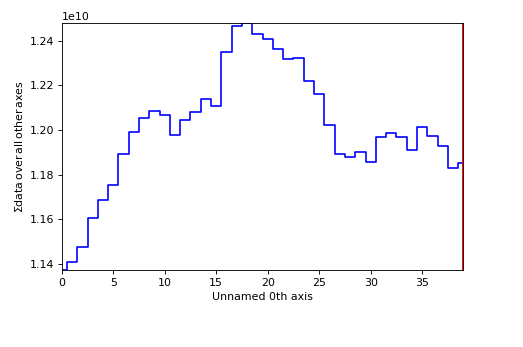

<IPython.core.display.Javascript object>


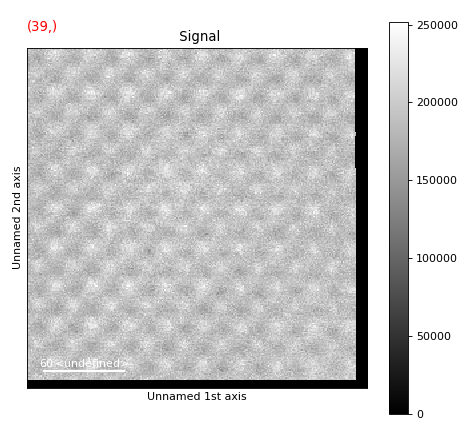

In [48]:
alignimage = hs.signals.Signal2D(defdata)
alignimage.plot()

dir(calculation)

In [39]:
x = calculation._MatchSeries__load_deformation(0, axis="x", refined=True)

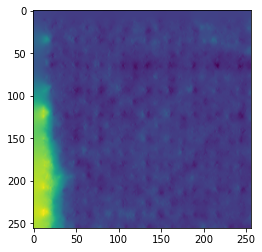

In [36]:
plt.imshow(x)

In [40]:
x = np.ones((40,256,256))
y = np.ones((40,256,256))
for frame in np.arange(40):
    x[frame] = calculation._MatchSeries__load_deformation(frame, axis="x", refined=True)
    y[frame] = calculation._MatchSeries__load_deformation(frame, axis="y", refined=True)

x = hs.signals.Signal2D(x)
y = hs.signals.Signal2D(y)


<IPython.core.display.Javascript object>


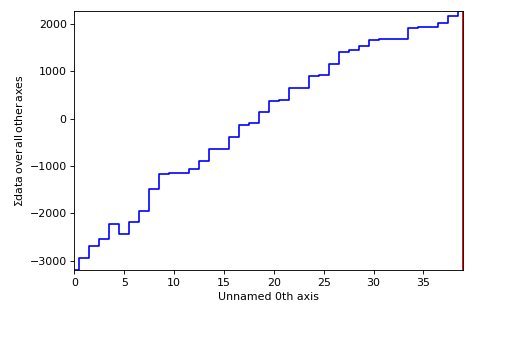

<IPython.core.display.Javascript object>


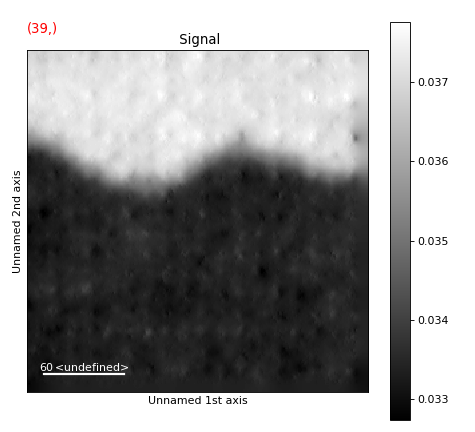

In [46]:
%matplotlib notebook
x.plot()

In [49]:
x.save('/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/NRR_results/xshifts.h5')
y.save('/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/NRR_results/yshifts.h5')

/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/sidpy/sid/translator.py:42: FutureWarning: Consider using sidpy.Reader instead of sidpy.Translator if possible and contribute your reader to ScopeReaders
  warn('Consider using sidpy.Reader instead of sidpy.Translator if '
/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:1129: UserWarning: pyUSID.io.hdf_utils.simple.write_ind_val_dsets no longer createsregion references for each dimension. Please use pyUSID.io.reg_ref.write_region_references to manually create region references
  warn('pyUSID.io.hdf_utils.simple.write_ind_val_dsets no longer creates'
/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/sidpy/sid/translator.py:42: FutureWarning: Consider using sidpy.Reader instead of sidpy.Translator if possible and contribute your reader to ScopeReaders
  warn('Consider using sidpy.Reader instead of sidpy.Translator if '


# After 4D register

In [10]:
import hyperspy.api as hs
from hyperspy import io_plugins
summ = hs.load('/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/summed_reg.hspy', lazy = True)


[########################################] | 100% Completed | 10.1s


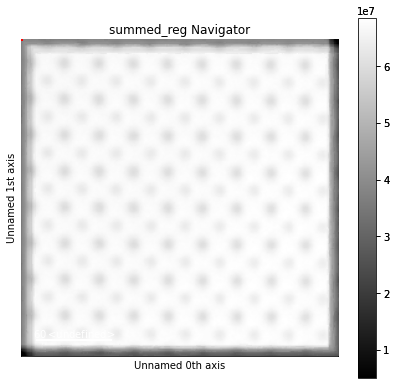

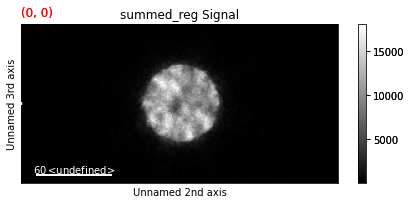

In [13]:
summ.plot()

In [15]:
summ.save('/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/summed_reg.hdf5')

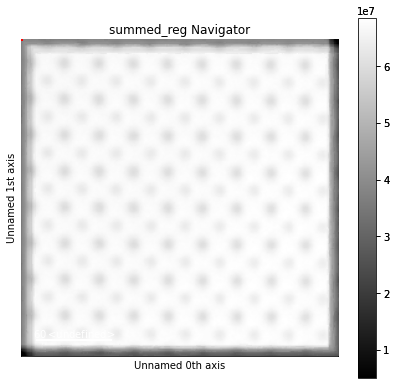

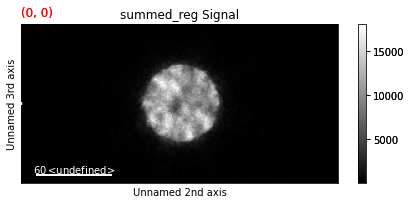

In [16]:
summ.plot()

# Make figure

In [69]:
ax[1][1].axis('off')

(0.0, 1.0, 0.0, 1.0)

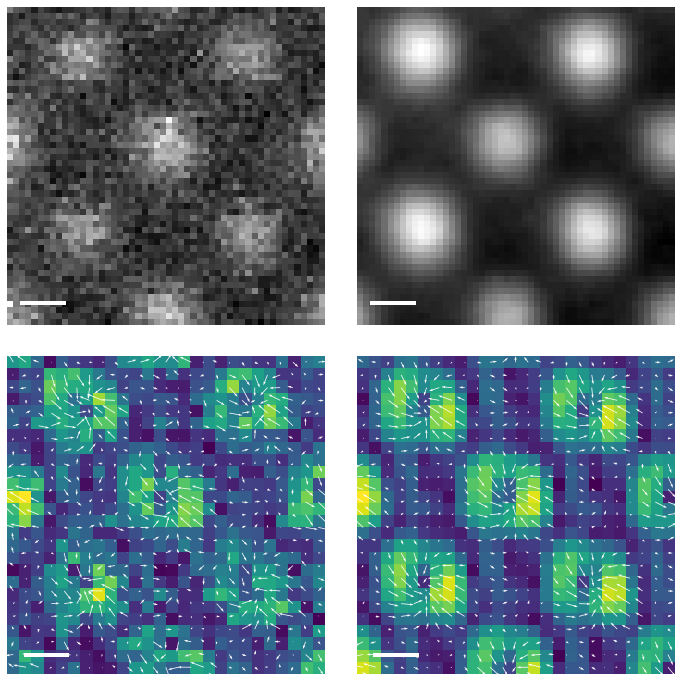

In [2]:
%matplotlib inline

from empyre.vis.colors import Colormap3D
from empyre.vis.colors import ColormapCubehelix
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig0, ax = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig0.tight_layout(h_pad = .01, w_pad = .1)
ax[0][0].axis('off')
ax[0][1].axis('off')
ax[1][0].axis('off')
ax[1][1].axis('off')

angstrom = 100/14.6/2
# scan step 7.9pm bin2 get 15.8
with h5py.File('/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/rawcom.h5', 'r') as F:
    Fx = F['x'][16:68, 26:78]
    Fy = F['y'][16:68, 26:78]
    Fx = scipy.ndimage.interpolation.zoom(Fx,0.5)
    Fy = scipy.ndimage.interpolation.zoom(Fy,0.5)
    commag = np.sqrt(Fx**2 + Fy**2)
    nrows, ncols = Fx.shape
    x = np.linspace(0, ncols, ncols)
    y = np.linspace(0, ncols, nrows)
    xi, yi = np.meshgrid(x, y)

    color = np.sqrt(Fx**2 + Fy**2)

    #ax0[0].quiver(xi, yi, Fx, Fy, color = 'w',  headwidth= 21,headlength= 19,headaxislength = 15)
    ax[1][0].quiver(xi, yi, Fx, -Fy, color = 'w')

    from empyre.vis.colors import ColormapCubehelix
    ch = ColormapCubehelix(start=0, rot=0, minLight=-0.1, maxLight=1.5, sat=13)
    
    #divergence =  np.gradient(Fx, axis=0) + np.gradient(Fy, axis=1)
    curl_2d = np.gradient(Fx, axis=1) - np.gradient(Fy, axis=0)

    #ax0[0].imshow(ch.rgb_from_vector((commag, 0, 0)))

    ax[1][0].plot([1,1+angstrom],[24,24],linewidth=4, c = 'white')
    ax[1][0].imshow(commag) 

with h5py.File('/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/regcom.h5', 'r') as F:
    Fx = F['x'][13:65, 24:76]
    Fy = F['y'][13:65, 24:76]
    Fx = scipy.ndimage.interpolation.zoom(Fx,0.5)
    Fy = scipy.ndimage.interpolation.zoom(Fy,0.5)
    commag = np.sqrt(Fx**2 + Fy**2)
    nrows, ncols = Fx.shape
    x = np.linspace(0, ncols, ncols)
    y = np.linspace(0, ncols, nrows)
    xi, yi = np.meshgrid(x, y)

    color = np.sqrt(Fx**2 + Fy**2)
    
    ax[1][1].plot([1,1+angstrom],[24,24],linewidth=4, c = 'white')

    ax[1][1].quiver(xi, yi, Fx, -Fy, color = 'w')
    ax[1][1].imshow(commag)
    

with h5py.File('/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/rawadf.h5', 'r') as F:
    ax[0][0].plot([2,2+angstrom*2],[48,48],linewidth=4, c = 'white')
    ax[0][0].imshow(F['intensity'][16:68, 26:78], cmap = 'gray')

    
with h5py.File('/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/regadf.h5', 'r') as F:
    ax[0][1].plot([2,2+angstrom*2],[48,48],linewidth=4, c = 'white')
    ax[0][1].imshow(F['intensity'][13:65, 24:76], cmap = 'gray')